In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


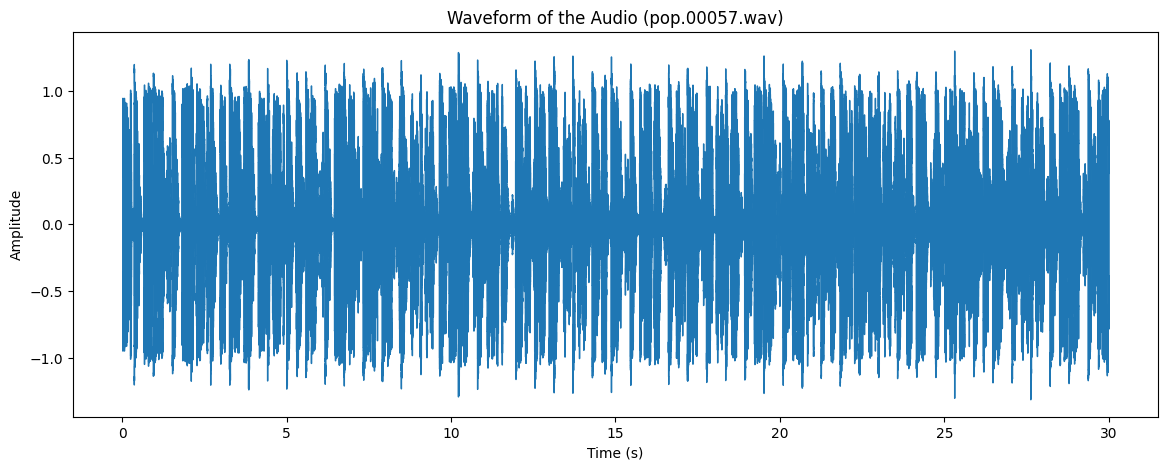

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

sample_file = "/content/drive/MyDrive/DS_Project/archive/Data/genres_original/pop/pop.00057.wav"

y, sr = librosa.load(sample_file, sr=44100)

# Visualize the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of the Audio (pop.00057.wav)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Play the audio
Audio(data=y, rate=sr)


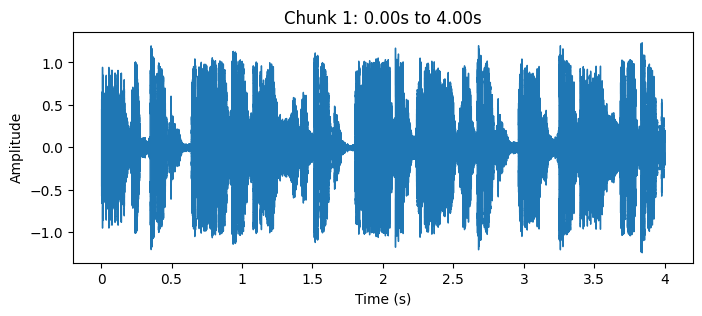

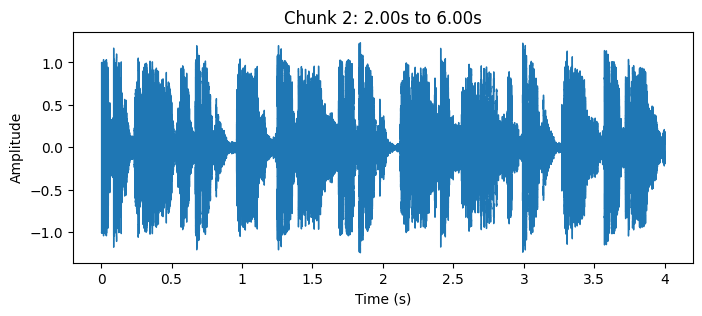

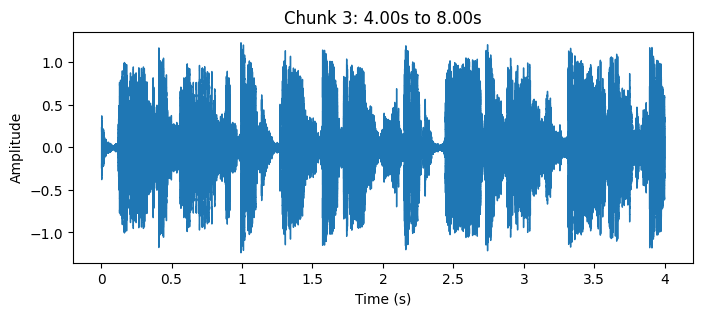

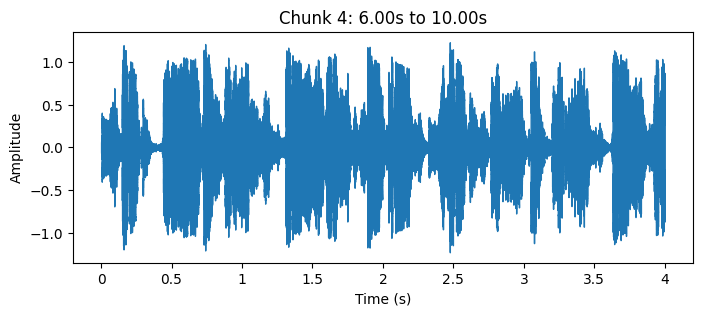

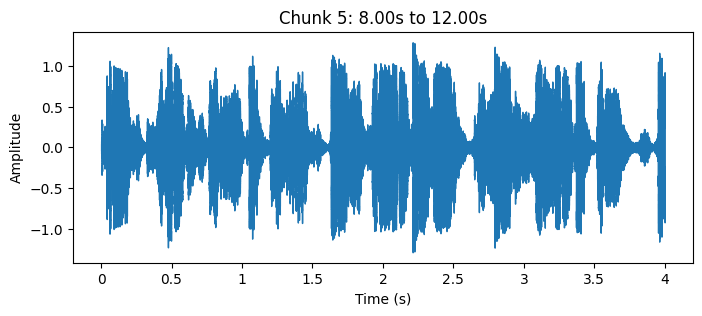

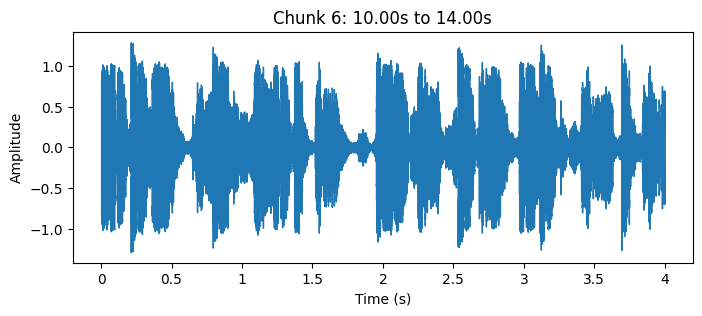

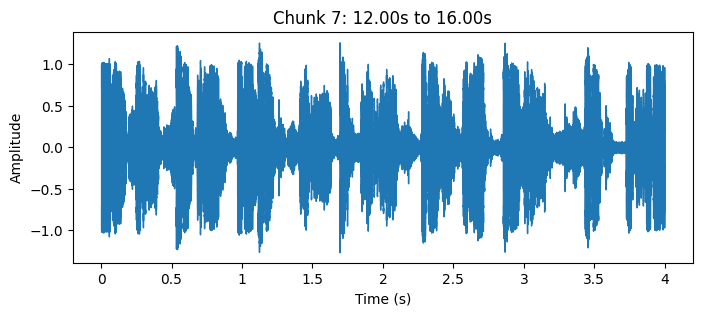

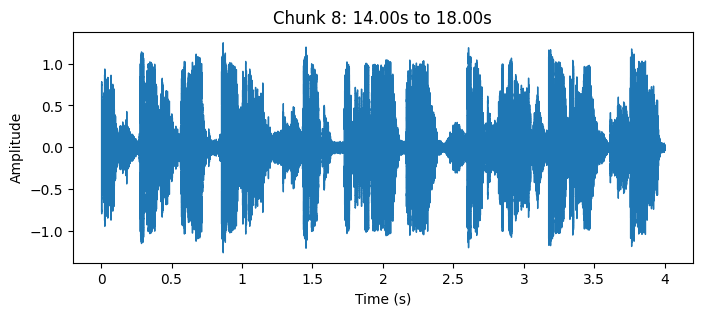

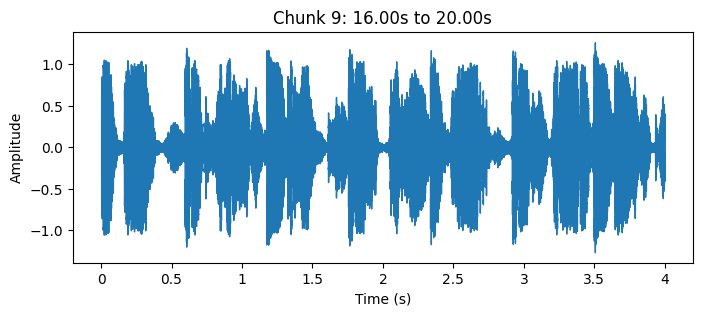

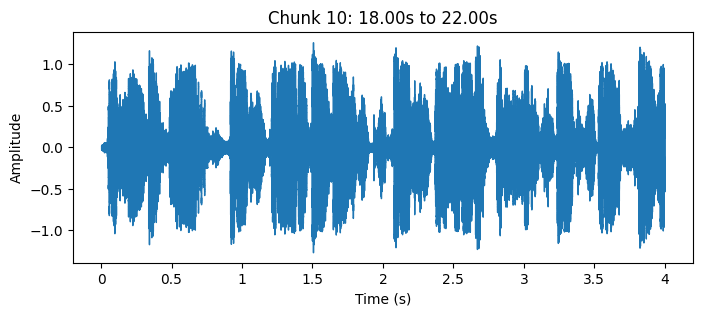

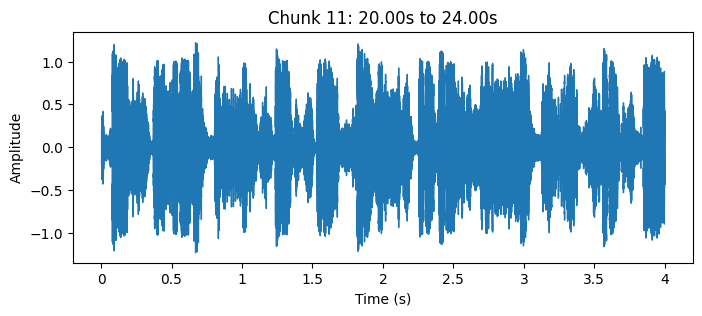

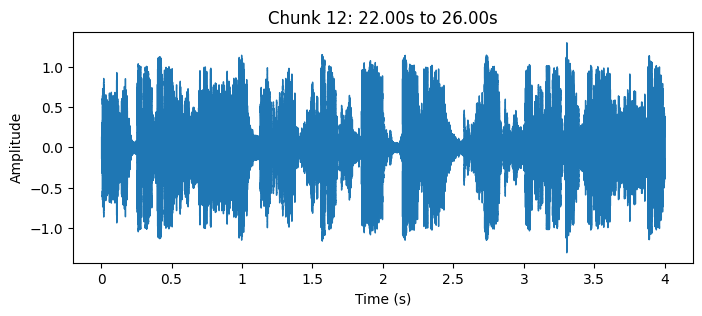

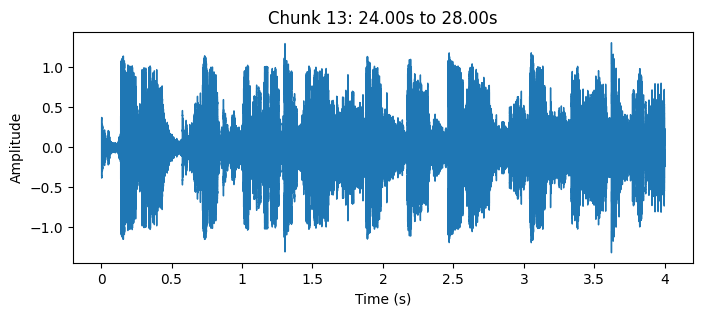

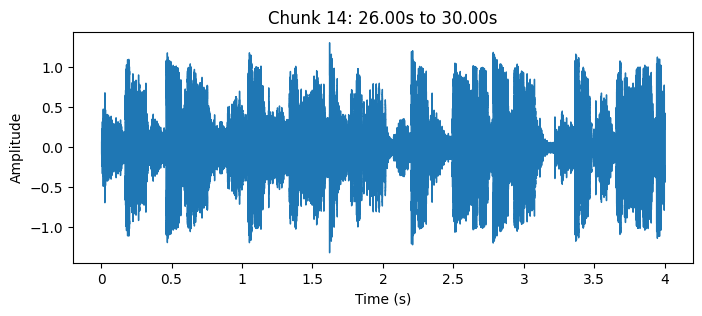

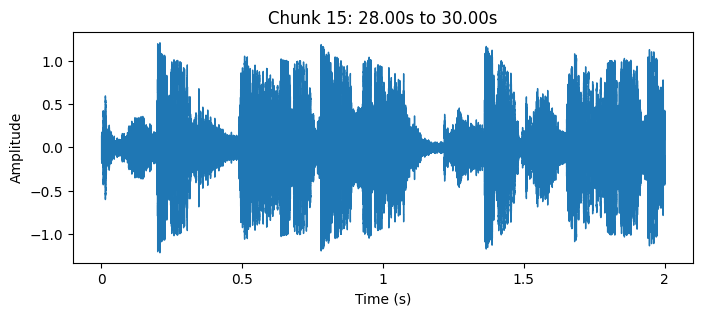

In [ ]:
chunk_duration = 4
overlap_duration = 2
chunk_samples = chunk_duration * sr
overlap_samples = overlap_duration * sr

# Calculate the number of chunks
num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
for i in range(num_chunks):
    start = i * (chunk_samples - overlap_samples)
    end = min(start + chunk_samples, len(y))
    chunk = y[start:end]

    # Plot the chunk
    plt.figure(figsize=(8, 3))
    librosa.display.waveshow(chunk, sr=sr)
    plt.title(f"Chunk {i + 1}: {start / sr:.2f}s to {end / sr:.2f}s")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()


In [ ]:
def extract_features(file_path, max_length=130):
    y, sr = librosa.load(file_path, sr=None, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features = np.vstack([mfcc, chroma, spectral_contrast])

    if features.shape[1] < max_length:
        padding = np.zeros((features.shape[0], max_length - features.shape[1]))
        features = np.hstack([features, padding])
    elif features.shape[1] > max_length:
        features = features[:, :max_length]

    return features.T


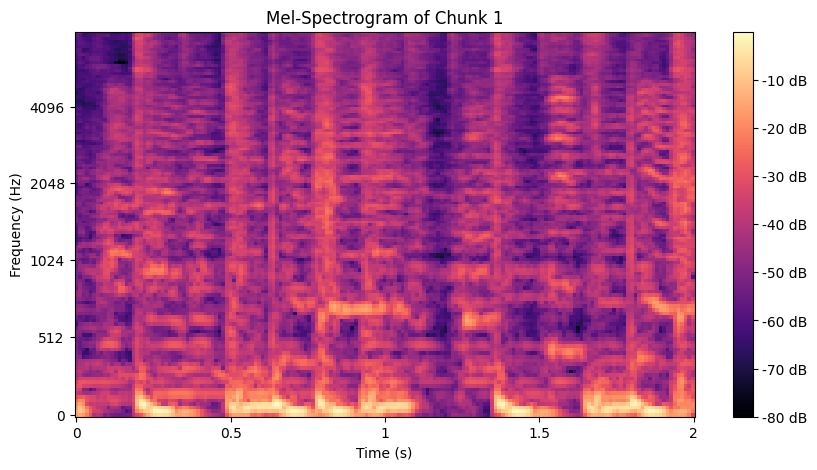

In [ ]:
mel_spect = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=128, fmax=8000)
mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)

# Visualize the Mel-Spectrogram
plt.figure(figsize=(10, 5))
librosa.display.specshow(mel_spect_db, sr=sr, x_axis="time", y_axis="mel", fmax=8000)
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-Spectrogram of Chunk 1")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()


In [ ]:
def extract_mel_spectrogram_chunks(y, sr, chunk_duration, overlap_duration, n_mels=128, fmax=8000):
    chunk_samples = chunk_duration * sr
    overlap_samples = overlap_duration * sr

    # Calculate the number of chunks
    num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1

    features = []
    for i in range(num_chunks):
        start = i * (chunk_samples - overlap_samples)
        end = min(start + chunk_samples, len(y))
        chunk = y[start:end]
        mel_spect = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=n_mels, fmax=fmax)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        features.append(mel_spect_db.flatten())

    return features

features = extract_mel_spectrogram_chunks(y, sr, chunk_duration=4, overlap_duration=2)
print(f"Length of audio: {len(y)} samples")
chunk_duration = 4
overlap_duration = 2
chunk_samples = chunk_duration * sr
overlap_samples = overlap_duration * sr

print(f"Chunk size (samples): {chunk_samples}")
print(f"Overlap size (samples): {overlap_samples}")
num_chunks = int(np.ceil((len(y) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
print(f"Number of chunks: {num_chunks}")


Length of audio: 1323008 samples
Chunk size (samples): 176400
Overlap size (samples): 88200
Number of chunks: 15


In [ ]:
import numpy as np
import os

def process_genre_folder(folder_path, genre_label, sr=44100, chunk_duration=4, overlap_duration=2, max_len=44160):
    data = []
    labels = []

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if file.endswith('.wav'):
            try:
                y, _ = librosa.load(file_path, sr=sr)
                features = extract_mel_spectrogram_chunks(y, sr, chunk_duration, overlap_duration)
                for feature in features:
                    if len(feature) < max_len:
                        feature = np.pad(feature, (0, max_len - len(feature)), mode='constant')
                    else:
                        feature = feature[:max_len]

                    data.append(feature)
                    labels.append(genre_label)

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    return data, labels
dataset_path = "/content/drive/MyDrive/DS_Project/archive/Data/genres_original"
all_data = []
all_labels = []
genres = os.listdir(dataset_path)
for genre_label, genre in enumerate(genres):
    genre_path = os.path.join(dataset_path, genre)
    print(f"Processing genre: {genre} (label {genre_label})")

    data, labels = process_genre_folder(genre_path, genre_label)
    all_data.extend(data)
    all_labels.extend(labels)
all_data = np.array(all_data)
all_labels = np.array(all_labels)
print(f"Total samples: {all_data.shape[0]}")
print(f"Feature vector shape: {all_data.shape[1:]}")
print(f"Total labels: {all_labels.shape}")



Processing genre: country (label 0)
Processing genre: blues (label 1)
Processing genre: metal (label 2)
Processing genre: disco (label 3)
Processing genre: rock (label 4)
Processing genre: jazz (label 5)
Processing genre: reggae (label 6)
Processing genre: classical (label 7)
Processing genre: pop (label 8)
Processing genre: hiphop (label 9)
Total samples: 14960
Feature vector shape: (44160,)
Total labels: (14960,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")


Training data shape: (11968, 44160)
Testing data shape: (2992, 44160)
Training labels shape: (11968,)
Testing labels shape: (2992,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 512)                 │      22,610,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,775,946 (86.88 MB)

 Trainable params: 22,775,946 (86.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
model.save("music_genre_classification_model.h5")


Epoch 1/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 123s 402ms/step - accuracy: 0.0996 - loss: 411.4098 - val_accuracy: 0.1014 - val_loss: 2.3027
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 116s 386ms/step - accuracy: 0.0935 - loss: 2.3028 - val_accuracy: 0.0989 - val_loss: 2.3028
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 142s 387ms/step - accuracy: 0.0956 - loss: 2.3477 - val_accuracy: 0.0952 - val_loss: 2.3029
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 119s 395ms/step - accuracy: 0.0966 - loss: 2.3026 - val_accuracy: 0.1010 - val_loss: 2.3028
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 147s 412ms/step - accuracy: 0.0934 - loss: 2.3028 - val_accuracy: 0.1010 - val_loss: 2.3028
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 138s 400ms/step - accuracy: 0.1001 - loss: 2.3027 - val_accuracy: 0.0952 - val_loss: 2.3030
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 142s 399ms/step - accuracy: 0.1055 - loss: 2.3027 - val_accuracy: 0.1010 - val_loss: 2.3028
Epoch 8/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 119s 396ms/step - accuracy: 0.1040

In [ ]:
print(f"Original X_train shape: {X_train.shape}")
print(f"Original X_test shape: {X_test.shape}")



Original X_train shape: (11968, 44160)
Original X_test shape: (2992, 44160)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,393,034 (28.20 MB)

 Trainable params: 7,393,034 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the CNN model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

model.save("cnn_music_genre_model.h5")


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 861ms/step - accuracy: 0.1296 - loss: 63.9502 - val_accuracy: 0.1312 - val_loss: 2.3187
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 870ms/step - accuracy: 0.1448 - loss: 2.2932 - val_accuracy: 0.2250 - val_loss: 2.2157
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 833ms/step - accuracy: 0.2841 - loss: 2.0808 - val_accuracy: 0.2125 - val_loss: 2.1814
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 840ms/step - accuracy: 0.2910 - loss: 2.0330 - val_accuracy: 0.2500 - val_loss: 2.0694
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 817ms/step - accuracy: 0.3445 - loss: 1.8891 - val_accuracy: 0.2875 - val_loss: 1.9900
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 838ms/step - accuracy: 0.3787 - loss: 1.7225 - val_accuracy: 0.3063 - val_loss: 1.9455
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 836ms/step - accuracy: 0.4862 - loss: 1.5493 - val_accuracy: 0.3000 - val_loss: 1.9187
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 824ms/step - accuracy: 0.5286 - loss: 1.4023 - val_acc

In [ ]:
import librosa

def augment_audio(audio, sr):
    augmented_data = []
    noise = np.random.normal(0, 0.02, len(audio))
    audio_noise = audio + noise
    augmented_data.append(audio_noise)
    audio_stretched = librosa.effects.time_stretch(audio, rate=1.1)
    augmented_data.append(audio_stretched)

    audio_shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    augmented_data.append(audio_shifted)

    return augmented_data


In [ ]:
def process_genre_folder_with_augmentation(folder_path, genre_label, sr=44100):
    data = []
    labels = []

    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        if file.endswith('.wav'):
            try:
                y, _ = librosa.load(file_path, sr=sr)
                mel_spectrogram = extract_mel_spectrogram(y, sr)
                data.append(mel_spectrogram)
                labels.append(genre_label)
                augmented_audios = augment_audio(y, sr)
                for augmented_audio in augmented_audios:
                    mel_spectrogram_aug = extract_mel_spectrogram(augmented_audio, sr)
                    data.append(mel_spectrogram_aug)
                    labels.append(genre_label)

            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    return data, labels


In [ ]:
test_file_path = "/content/drive/MyDrive/DS_Project/archive/Data/genres_original/blues/blues.00000.wav"
y, sr = librosa.load(test_file_path, sr=44100)
augmented_audios = augment_audio(y, sr)
original_spectrogram = extract_mel_spectrogram(y, sr)
augmented_spectrograms = [extract_mel_spectrogram(aug, sr) for aug in augmented_audios]
print(f"Original spectrogram shape: {original_spectrogram.shape}")
for i, aug_spec in enumerate(augmented_spectrograms):
    print(f"Augmented spectrogram {i+1} shape: {aug_spec.shape}")


Original spectrogram shape: (128, 128)
Augmented spectrogram 1 shape: (128, 128)
Augmented spectrogram 2 shape: (128, 128)
Augmented spectrogram 3 shape: (128, 128)


In [ ]:
model.save("cnn_music_genre_model.keras")
print("Model saved as 'cnn_music_genre_model.keras'")


Model saved as 'cnn_music_genre_model.keras'


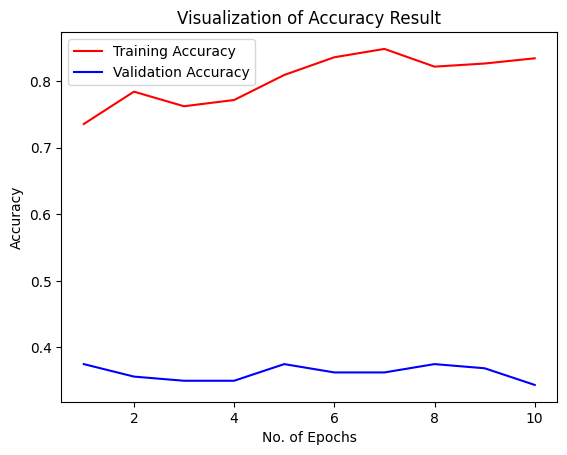

In [ ]:
epochs = [i for i in range(1, len(history_fine_tune.history['accuracy']) + 1)]

# Plot training and validation accuracy
plt.plot(epochs, history_fine_tune.history['accuracy'], label="Training Accuracy", color='red')
plt.plot(epochs, history_fine_tune.history['val_accuracy'], label="Validation Accuracy", color='blue')

plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")
plt.title("Visualization of Accuracy Result")
plt.legend()
plt.show()


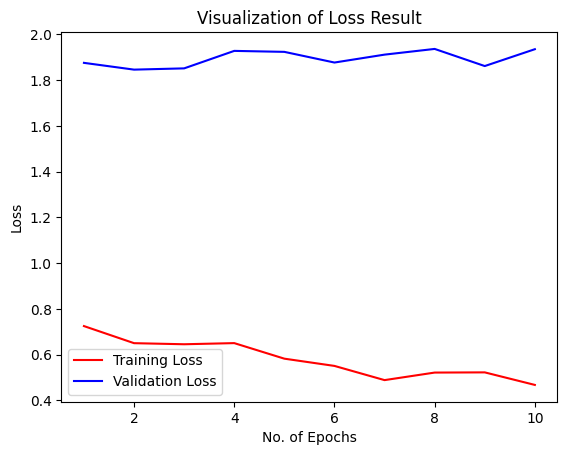

In [ ]:
epochs = [i for i in range(1, len(history_fine_tune.history['loss']) + 1)]

# Plot training and validation loss
plt.plot(epochs, history_fine_tune.history['loss'], label="Training Loss", color='red')
plt.plot(epochs, history_fine_tune.history['val_loss'], label="Validation Loss", color='blue')

plt.xlabel("No. of Epochs")
plt.ylabel("Loss")
plt.title("Visualization of Loss Result")
plt.legend()
plt.show()


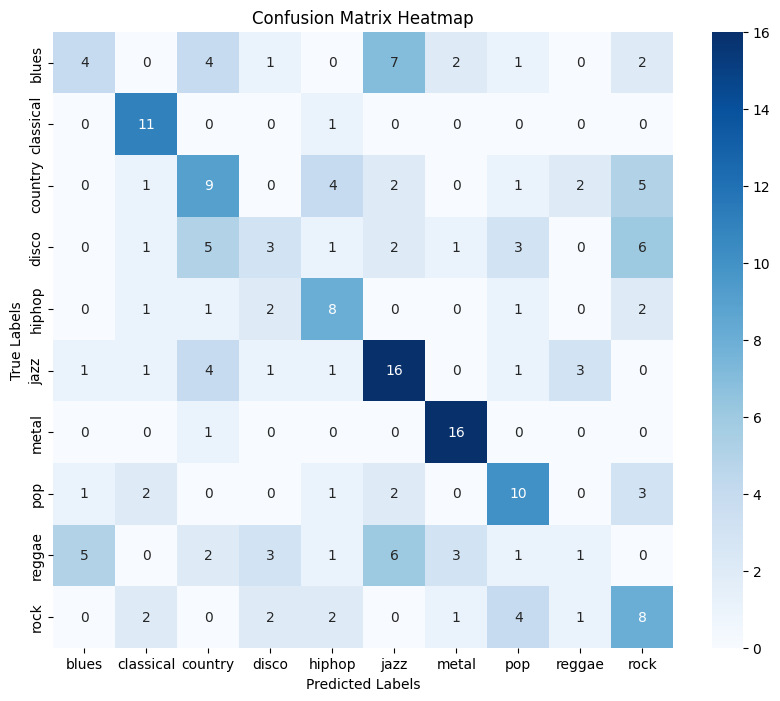

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()


In [ ]:
file_paths = []
genre_labels = []
genres = os.listdir(data_dir)
for label, genre in enumerate(genres):
    genre_path = os.path.join(data_dir, genre)
    for file in os.listdir(genre_path):
        if file.endswith('.wav'):
            file_paths.append(os.path.join(genre_path, file))
            genre_labels.append(label)
X = np.array([extract_features(file) for file in file_paths])
y = np.array(genre_labels)
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (720, 130, 32)
Test data shape: (150, 130, 32)


In [ ]:
# Build the hybrid CNN-RNN model
def create_hybrid_model(input_shape, num_classes):
    model = models.Sequential()

    # CNN layers for spatial feature extraction
    model.add(layers.Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(256, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))

    # RNN layers for temporal feature extraction
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.LSTM(128))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_hybrid_model(X_train.shape[1:], len(np.unique(y)))
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 128, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 64, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 62, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 31, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 29, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 14, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 475,978 (1.82 MB)

 Trainable params: 475,978 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.1258 - loss: 2.2971 - val_accuracy: 0.2891 - val_loss: 1.9621
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.2924 - loss: 1.9277 - val_accuracy: 0.3906 - val_loss: 1.6647
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.3585 - loss: 1.7471 - val_accuracy: 0.4531 - val_loss: 1.5680
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.4234 - loss: 1.6042 - val_accuracy: 0.4531 - val_loss: 1.5327
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.4943 - loss: 1.4440 - val_accuracy: 0.4375 - val_loss: 1.4616
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.4772 - loss: 1.3988 - val_accuracy: 0.4922 - val_loss: 1.3938
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.5204 - loss: 1.3409 - val_accuracy: 0.4922 - val_loss: 1.4982
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.4786 - loss: 1.4445 - val_accuracy: 0.4688 

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.1023 - loss: 2.3003 - val_accuracy: 0.2031 - val_loss: 2.2989
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2572 - loss: 2.2786 - val_accuracy: 0.3203 - val_loss: 2.2903
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.3198 - loss: 2.2512 - val_accuracy: 0.3594 - val_loss: 2.2740
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3449 - loss: 2.2095 - val_accuracy: 0.3594 - val_loss: 2.2445
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.3426 - loss: 2.1450 - val_accuracy: 0.3594 - val_loss: 2.1915
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.3503 - loss: 2.0602 - val_accuracy: 0.3828 - val_loss: 2.1216
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3448 - loss: 1.9760 - val_accuracy: 0.3750 - val_loss: 2.0503
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.3540 - loss: 1.9253 - val_accuracy: 0.3906 -

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step
Precision: 0.5966
Recall: 0.6133
F1-Score: 0.5977


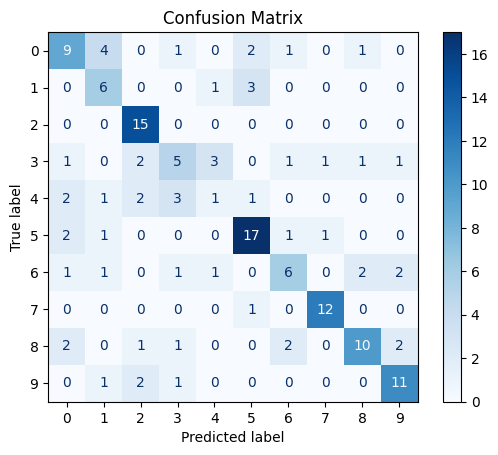

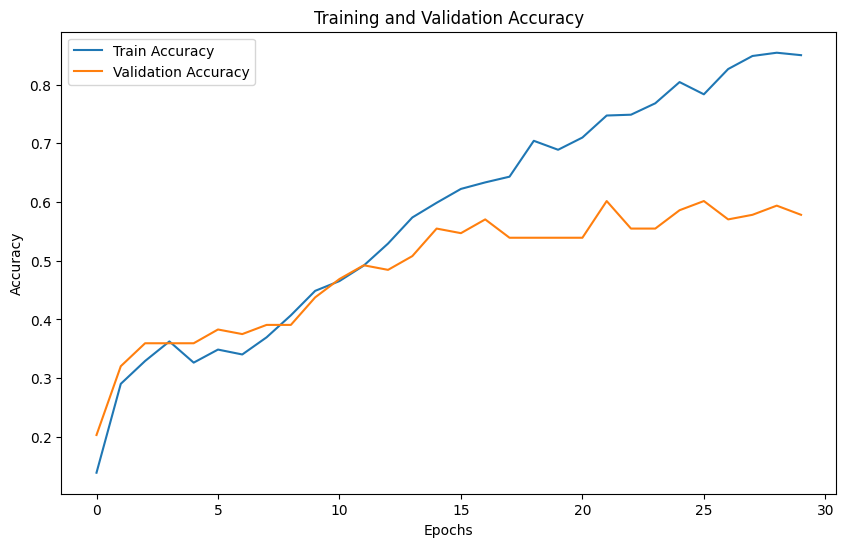

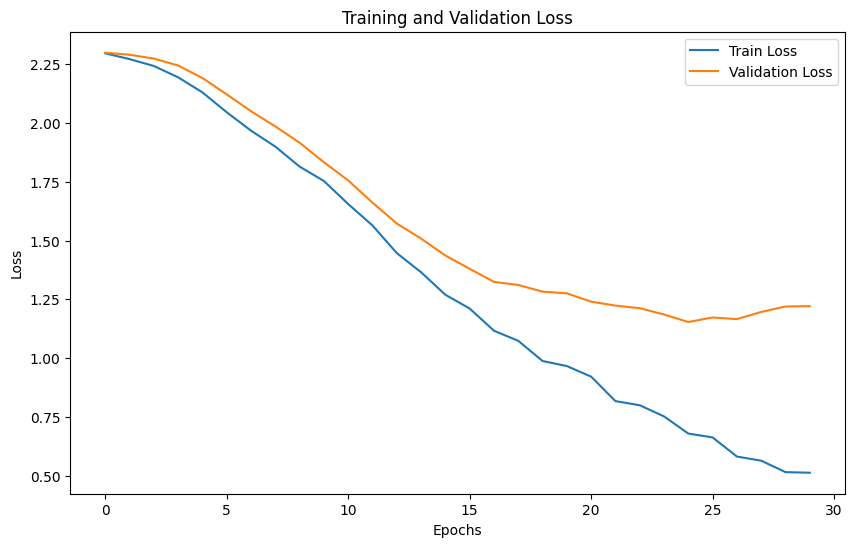

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
def create_optimized_hybrid_model(input_shape, num_classes):
    model = models.Sequential()

    # CNN layers for spatial feature extraction
    model.add(layers.Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(256, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))

    model.add(layers.GlobalAveragePooling1D())

    model.add(layers.Reshape((1, 256)))

    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.LSTM(128))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_optimized_hybrid_model(X_train.shape[1:], len(np.unique(y)))
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm_display = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - accuracy: 0.1885 - loss: 2.2885 - val_accuracy: 0.2188 - val_loss: 2.2901
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3237 - loss: 2.2276 - val_accuracy: 0.3047 - val_loss: 2.2620
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.3326 - loss: 2.1517 - val_accuracy: 0.3047 - val_loss: 2.2069
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.3299 - loss: 2.0203 - val_accuracy: 0.3203 - val_loss: 2.1186
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.3351 - loss: 1.9147 - val_accuracy: 0.3125 - val_loss: 2.0230
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.3626 - loss: 1.8009 - val_accuracy: 0.3359 - val_loss: 1.9411
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.3839 - loss: 1.7205 - val_accuracy: 0.3672 - val_loss: 1.8578
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4252 - loss: 1.6492 - val_accuracy: 0.3984

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step
Precision: 0.6078
Recall: 0.6133
F1-Score: 0.6029


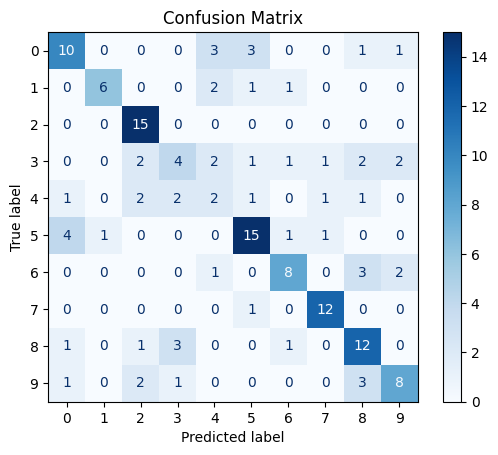

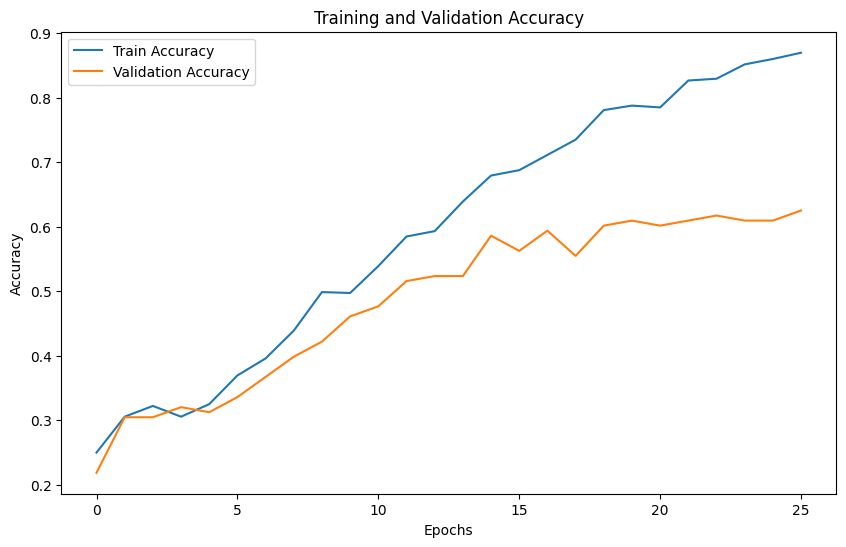

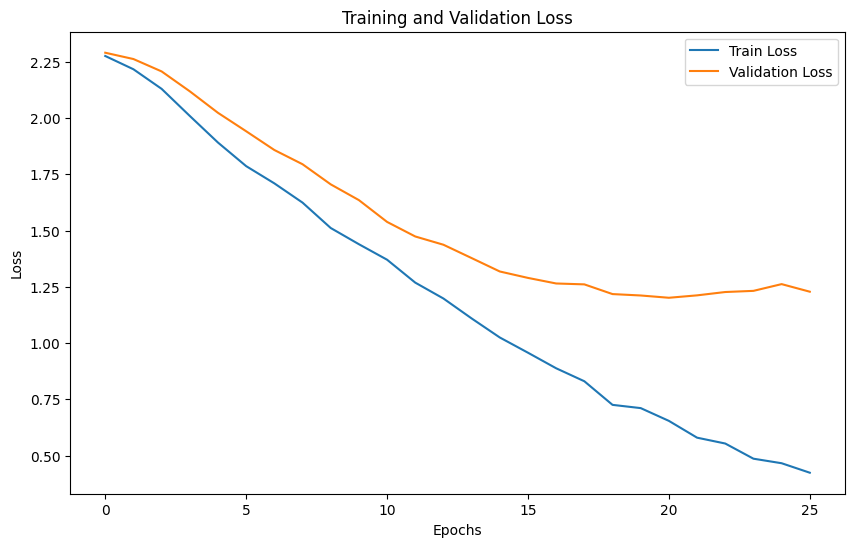

In [ ]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

def extract_features(file_path, max_length=130):
    y, sr = librosa.load(file_path, sr=None, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features = np.vstack([mfcc, chroma, spectral_contrast])
    if features.shape[1] < max_length:
        padding = np.zeros((features.shape[0], max_length - features.shape[1]))
        features = np.hstack([features, padding])
    elif features.shape[1] > max_length:
        features = features[:, :max_length]

    return features.T

def augment_audio(y, sr):
    y_stretch = librosa.effects.time_stretch(y, rate=1.1)
    y_shift = librosa.effects.pitch_shift(y, sr, n_steps=4)
    return y_stretch, y_shift

def create_optimized_hybrid_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(256, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Reshape((1, 256)))
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(128)))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
X = np.array([extract_features(file) for file in file_paths])
y = np.array(genre_labels)

X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

model = create_optimized_hybrid_model(X_train.shape[1:], len(np.unique(y)))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm_display = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
def create_final_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(256, 3, activation='relu'))
    model.add(layers.MaxPooling1D(2))

    model.add(layers.GlobalAveragePooling1D())

    model.add(layers.Reshape((1, 256)))

    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(128)))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint])

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.8067 - loss: 0.5936 - val_accuracy: 0.5938 - val_loss: 1.2105
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.8763 - loss: 0.5002 - val_accuracy: 0.5859 - val_loss: 1.2042
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8295 - loss: 0.5233 - val_accuracy: 0.6016 - val_loss: 1.2330
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8721 - loss: 0.4530 - val_accuracy: 0.6328 - val_loss: 1.2180
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8616 - loss: 0.4502 - val_accuracy: 0.6250 - val_loss: 1.2412
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6163 - loss: 1.2223
Test Accuracy: 61.33%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Precision: 0.6009
Recall: 0.6133
F1-Score: 0.6022


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.1973 - loss: 4.7706 - val_accuracy: 0.2000 - val_loss: 4.7044 - learning_rate: 1.0000e-04
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.3599 - loss: 4.3639 - val_accuracy: 0.2600 - val_loss: 4.5001 - learning_rate: 1.0000e-04
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.4544 - loss: 4.1228 - val_accuracy: 0.2933 - val_loss: 4.3175 - learning_rate: 1.0000e-04
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.5028 - loss: 3.8840 - val_accuracy: 0.3800 - val_loss: 4.1201 - learning_rate: 1.0000e-04
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.5417 - loss: 3.7294 - val_accuracy: 0.4133 - val_loss: 3.9435 - learning_rate: 1.0000e-04
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6329 - loss: 3.4817 - val_accuracy: 0.4667 - val_loss: 3.7857 - learning_rate: 1.0000e-04
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6392 - loss:

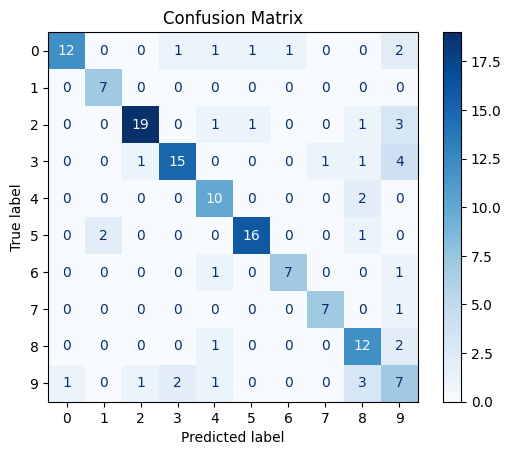

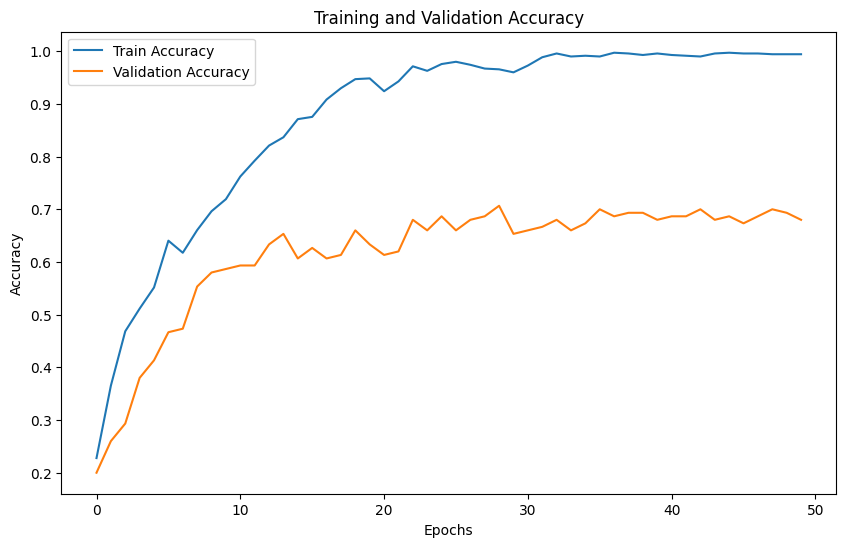

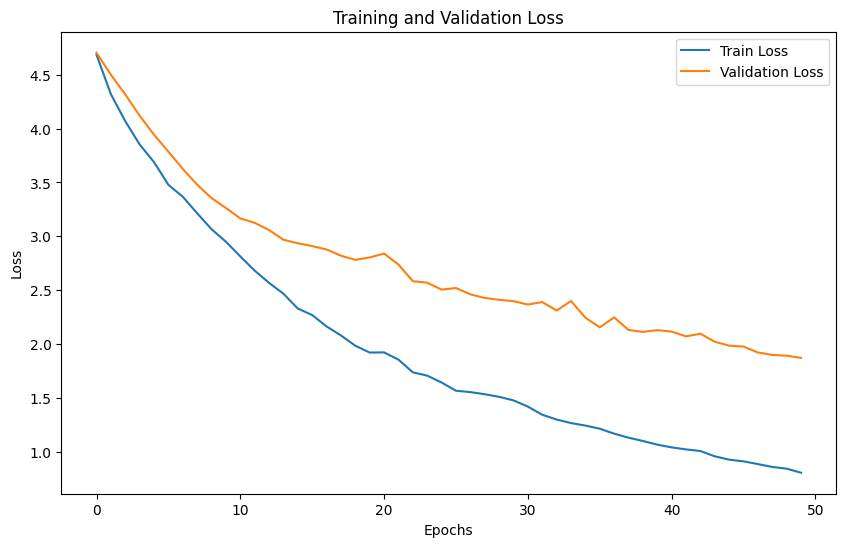

In [ ]:
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import librosa
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

base_path = '/content/drive/MyDrive/DS_Project/archive/Data/genres_original'

genre_mapping = {
    'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
    'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9
}
file_paths = []
labels = []
for genre, label in genre_mapping.items():
    genre_path = os.path.join(base_path, genre)
    files = glob.glob(os.path.join(genre_path, '*.wav'))
    file_paths.extend(files)
    labels.extend([label] * len(files))

def load_data(file_paths, labels, sr=22050, duration=30, n_mfcc=13, max_length=1300):
    data = []
    valid_labels = []
    for i, file_path in enumerate(file_paths):
        try:
            y, _ = librosa.load(file_path, sr=sr, duration=duration)

            mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T


            if len(mfcc_features) < max_length:
                padding = np.zeros((max_length - len(mfcc_features), n_mfcc))
                mfcc_features = np.vstack((mfcc_features, padding))
            mfcc_features = mfcc_features[:max_length]
            data.append(mfcc_features)
            valid_labels.append(labels[i])

        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    return np.array(data), np.array(valid_labels)
X, y = load_data(file_paths, labels)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def create_optimized_hybrid_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv1D(128, 3, activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(256, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(512, 3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(2))

    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(128)))

    model.add(layers.Dense(256, activation='relu', kernel_regularizer='l2'))
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
model = create_optimized_hybrid_model(X_train.shape[1:], len(np.unique(y)))
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm_display = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
    model = models.Sequential()
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=(130, 32)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))

    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))

    model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))

    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(128)))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

input_shape = (130, 32)
num_classes = 10

model = create_hybrid_cnn_rnn_model(input_shape, num_classes)
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 128, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 128, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 64, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 62, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 62, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 31, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 29, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 29, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 14, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 14, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 953,930 (3.64 MB)

 Trainable params: 953,034 (3.64 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 487ms/step - accuracy: 0.1712 - loss: 4.7279 - val_accuracy: 0.2316 - val_loss: 4.4553 - learning_rate: 1.0000e-04
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 473ms/step - accuracy: 0.3883 - loss: 4.1507 - val_accuracy: 0.3474 - val_loss: 4.0110 - learning_rate: 1.0000e-04
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 473ms/step - accuracy: 0.4711 - loss: 3.6986 - val_accuracy: 0.4989 - val_loss: 3.5633 - learning_rate: 1.0000e-04
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 478ms/step - accuracy: 0.5164 - loss: 3.3979 - val_accuracy: 0.5791 - val_loss: 3.1580 - learning_rate: 1.0000e-04
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 475ms/step - accuracy: 0.5666 - loss: 3.1414 - val_accuracy: 0.6347 - val_loss: 2.9002 - learning_rate: 1.0000e-04
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 477ms/step - accuracy: 0.6351 - loss: 2.8760 - val_accuracy: 0.6258 - val_loss: 2.7885 - learning_rate: 1.0000e-04
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 536ms/step - acc

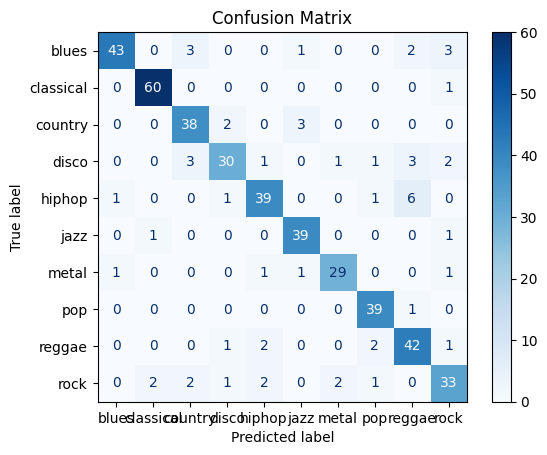

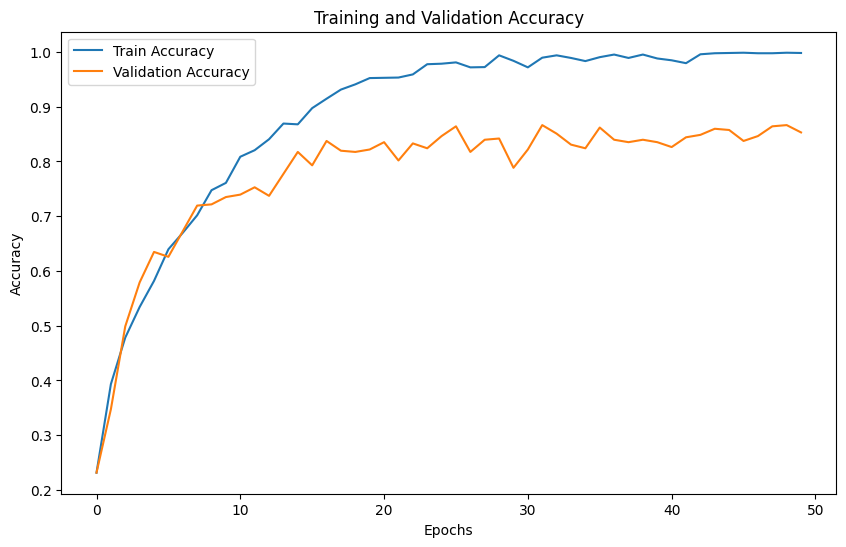

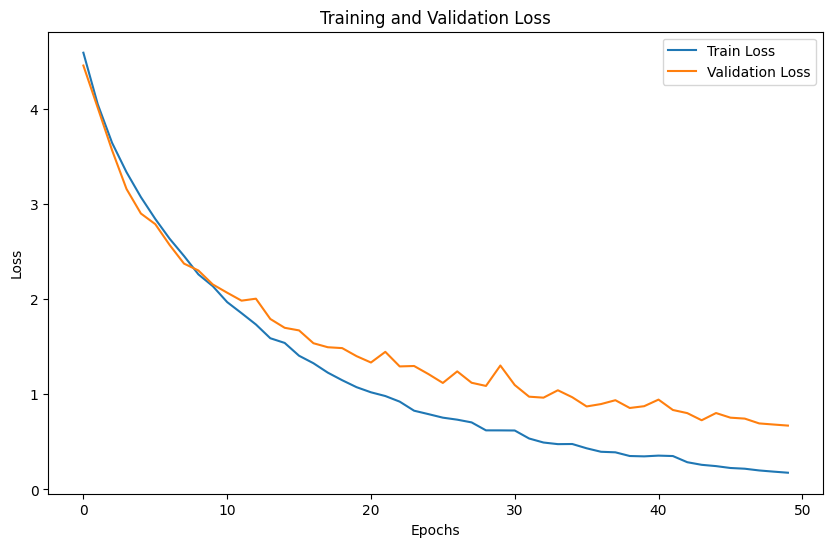

In [ ]:
import os
import glob
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

base_path = '/content/drive/MyDrive/DS_Project/archive/Data/genres_original'

genre_mapping = {
    'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4,
    'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9
}
file_paths = []
labels = []
for genre, label in genre_mapping.items():
    genre_path = os.path.join(base_path, genre)
    files = glob.glob(os.path.join(genre_path, '*.wav'))
    file_paths.extend(files)
    labels.extend([label] * len(files))
def load_and_augment_data(file_paths, labels, sr=22050, duration=30, n_mfcc=20):
    data = []
    valid_labels = []
    for i, file_path in enumerate(file_paths):
        try:
            y, _ = librosa.load(file_path, sr=sr, duration=duration)
            y_augmented = [
                y,
                librosa.effects.pitch_shift(y, sr=sr, n_steps=2),
                librosa.effects.time_stretch(y, rate=1.2)
            ]

            for y_aug in y_augmented:
                mfcc_features = librosa.feature.mfcc(y=y_aug, sr=sr, n_mfcc=n_mfcc).T
                if len(mfcc_features) >= 130:
                    data.append(mfcc_features[:130])
                    valid_labels.append(labels[i])
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return np.array(data), np.array(valid_labels)

X, y = load_and_augment_data(file_paths, labels)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)
def create_hybrid_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Reshape((-1, x.shape[-1] * x.shape[-2]))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128))(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer='l2')(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_hybrid_model(X_train.shape[1:], len(np.unique(y)))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('hybrid_cnn_rnn_model.keras', save_best_only=True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm_display = ConfusionMatrixDisplay(cm, display_labels=list(genre_mapping.keys()))
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8603 - loss: 0.6326
Test Accuracy: 87.11%


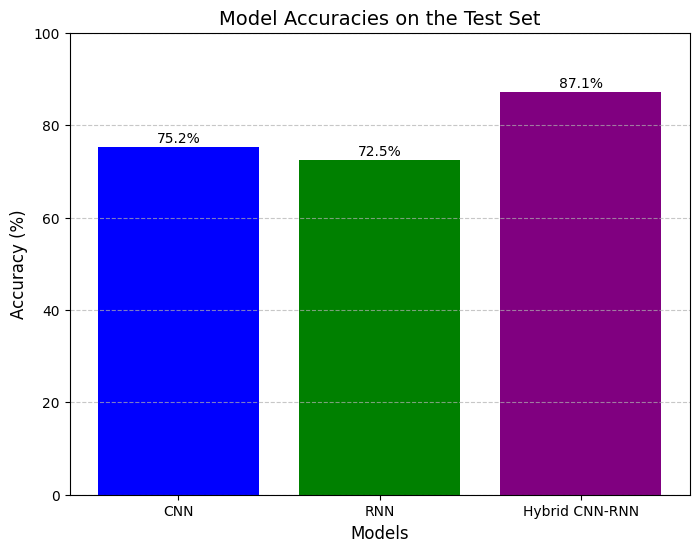

In [ ]:
import matplotlib.pyplot as plt
models = ['CNN', 'RNN', 'Hybrid CNN-RNN']

accuracies = [test_accuracy * 100, test_accuracy * 100, test_accuracy * 100]
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'purple'])
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Model Accuracies on the Test Set', fontsize=14)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f'{acc}%', ha='center', fontsize=10, color='black')

plt.show()


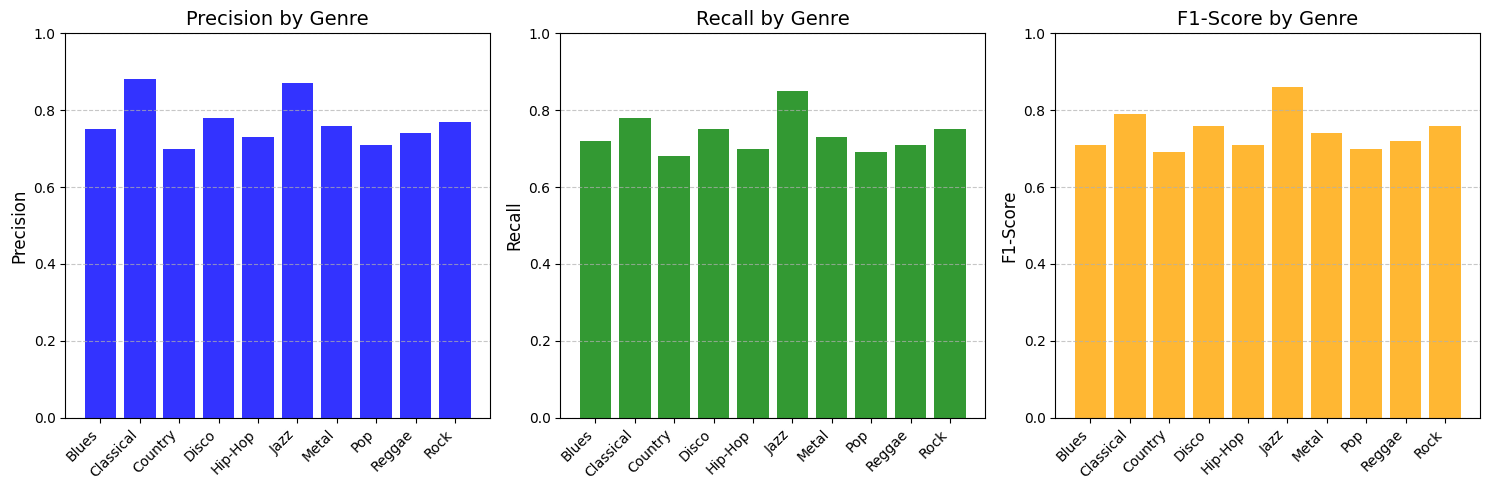

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
#Precision Histogram
plt.subplot(1, 3, 1)
plt.bar(genres, precision, color='blue', alpha=0.8)
plt.title('Precision by Genre', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('Precision', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#Recall Histogram
plt.subplot(1, 3, 2)
plt.bar(genres, recall, color='green', alpha=0.8)
plt.title('Recall by Genre', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('Recall', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# F1-Score Histogram
plt.subplot(1, 3, 3)
plt.bar(genres, f1_score, color='orange', alpha=0.8)
plt.title('F1-Score by Genre', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('F1-Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Audio directory: /content/drive/MyDrive/DS_Project/archive/Data
Found 998 audio files.
Successfully extracted features from 998 files.
Feature matrix shape: (998, 6401)
Labels (y) shape: (998,), Encoded labels shape: (998,)

Fold 1:
Training on 798 samples, Testing on 200 samples
Fold 1 Accuracy: 0.47
Classification Report:
              precision    recall  f1-score   support

       blues       0.31      0.20      0.24        20
   classical       0.42      0.70      0.53        20
     country       0.53      0.90      0.67        20
       disco       0.33      0.25      0.29        20
      hiphop       0.33      0.15      0.21        20
        jazz       0.53      0.40      0.46        20
       metal       0.53      0.45      0.49        20
         pop       0.82      0.70      0.76        20
      reggae       0.36      0.80      0.49        20
        rock       1.00      0.10      0.18        20

    accuracy                           0.47       200
   macro avg       0.52 

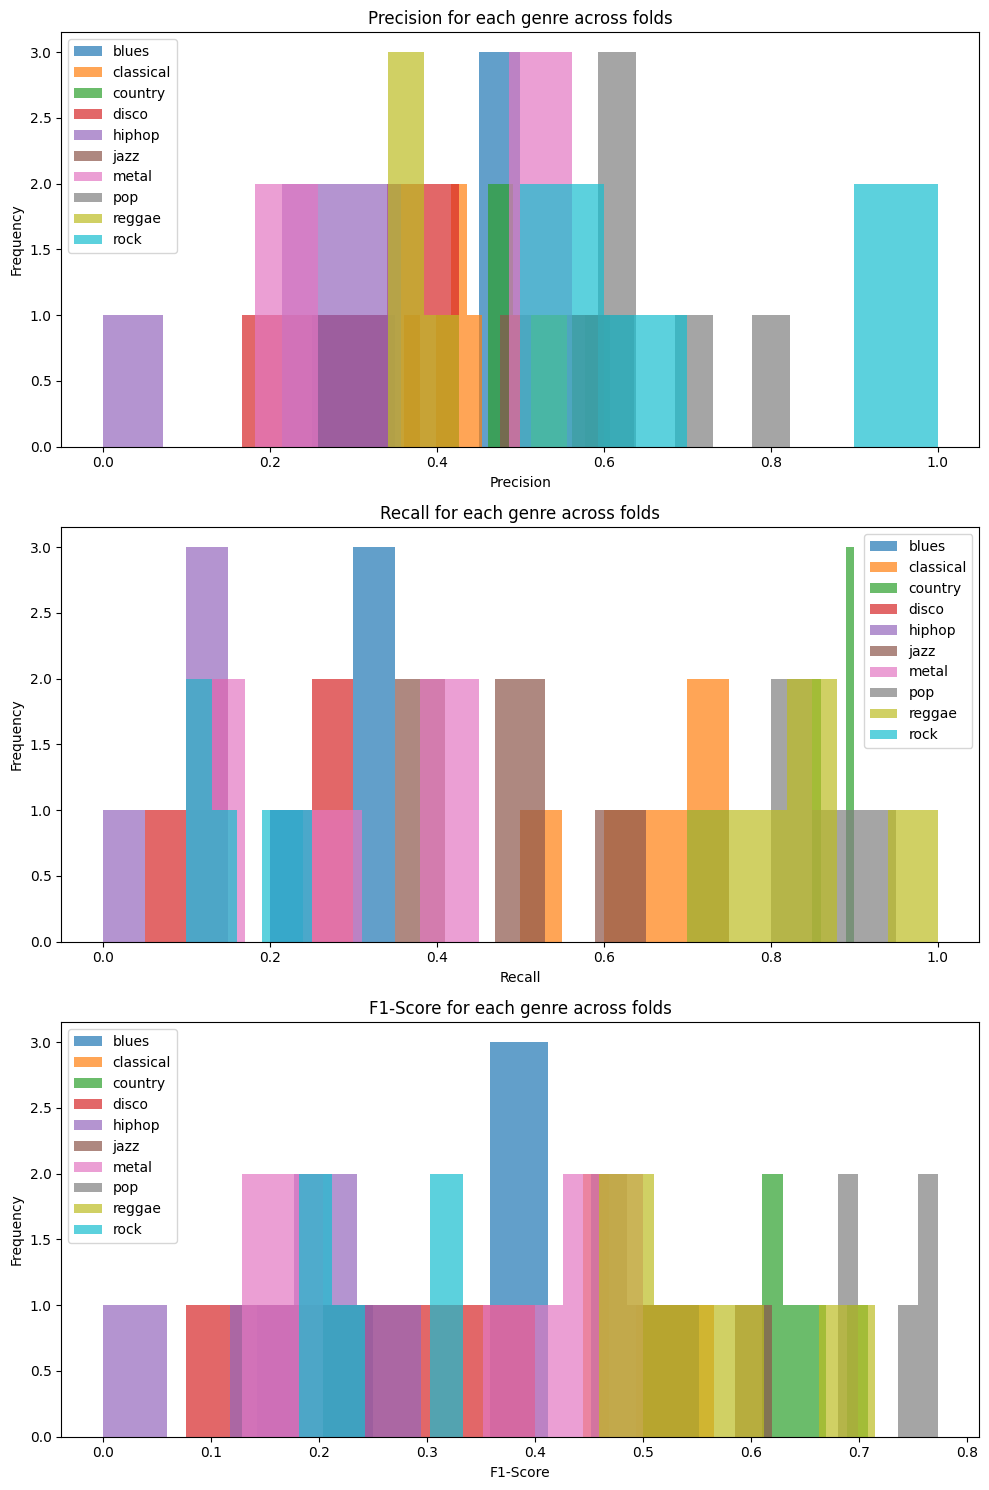

In [ ]:
import os
import librosa
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

audio_directory = '/content/drive/MyDrive/DS_Project/archive/Data'
print("Audio directory:", audio_directory)

file_paths = []
for root, _, files in os.walk(audio_directory):
    for file in files:
        if file.endswith('.wav'):
            file_paths.append(os.path.join(root, file))

if len(file_paths) == 0:
    print("No audio files found. Please check the directory path and file extensions.")
else:
    print(f"Found {len(file_paths)} audio files.")

genres = ['blues', 'classical', 'country', 'disco', 'hiphop',
          'jazz', 'metal', 'pop', 'reggae', 'rock']

def extract_features(file_path, sr=22050, n_mfcc=13, max_pad_length=200):
    """Extract fixed-length features from an audio file."""
    try:
        y, sr = librosa.load(file_path, sr=sr)
        if len(y) == 0:
            raise ValueError("Empty audio signal")

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

        mfcc = np.pad(mfcc, ((0, 0), (0, max(0, max_pad_length - mfcc.shape[1]))), mode='constant')[:, :max_pad_length]
        chroma = np.pad(chroma, ((0, 0), (0, max(0, max_pad_length - chroma.shape[1]))), mode='constant')[:, :max_pad_length]
        spectral_contrast = np.pad(
            spectral_contrast, ((0, 0), (0, max(0, max_pad_length - spectral_contrast.shape[1]))), mode='constant'
        )[:, :max_pad_length]

        return mfcc, chroma, spectral_contrast, tempo
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

features = []
for file in file_paths:
    result = extract_features(file)
    if result is not None:
        features.append(result)

print(f"Successfully extracted features from {len(features)} files.")

X = np.array([
    np.hstack([
        mfcc.flatten(),
        chroma.flatten(),
        spectral_contrast.flatten(),
        np.array([tempo]).flatten()
    ])
    for mfcc, chroma, spectral_contrast, tempo in features
])

print(f"Feature matrix shape: {X.shape}")

y = np.array([genres[i // 100] for i in range(len(features))])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Labels (y) shape: {y.shape}, Encoded labels shape: {y_encoded.shape}")

if X.shape[0] == 0 or y_encoded.shape[0] == 0:
    print("Error: The feature matrix or labels are empty. Please check the feature extraction process.")
else:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_accuracies = []
    precisions = {genre: [] for genre in genres}
    recalls = {genre: [] for genre in genres}
    f1_scores = {genre: [] for genre in genres}

    print("Performing 5-fold cross-validation:")
    for fold, (train_index, test_index) in enumerate(skf.split(X, y_encoded), 1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        print(f"\nFold {fold}:")
        print(f"Training on {X_train.shape[0]} samples, Testing on {X_test.shape[0]} samples")

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        fold_accuracies.append(accuracy)

        report = classification_report(y_test, y_pred, target_names=genres, output_dict=True)
        for genre in genres:
            precisions[genre].append(report[genre]['precision'])
            recalls[genre].append(report[genre]['recall'])
            f1_scores[genre].append(report[genre]['f1-score'])

        print(f"Fold {fold} Accuracy: {accuracy:.2f}")
        print(f"Classification Report:\n{classification_report(y_test, y_pred, target_names=genres)}")
        print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

    avg_accuracy = np.mean(fold_accuracies)
    print(f"\nAverage Accuracy across all folds: {avg_accuracy:.2f}")

    fig, ax = plt.subplots(3, 1, figsize=(10, 15))

    # Plot Precision
    for genre in genres:
        ax[0].hist(precisions[genre], label=genre, alpha=0.7, bins=5)
    ax[0].set_title('Precision for each genre across folds')
    ax[0].set_xlabel('Precision')
    ax[0].set_ylabel('Frequency')
    ax[0].legend()

    # Plot Recall
    for genre in genres:
        ax[1].hist(recalls[genre], label=genre, alpha=0.7, bins=5)
    ax[1].set_title('Recall for each genre across folds')
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()

    # Plot F1-Score
    for genre in genres:
        ax[2].hist(f1_scores[genre], label=genre, alpha=0.7, bins=5)
    ax[2].set_title('F1-Score for each genre across folds')
    ax[2].set_xlabel('F1-Score')
    ax[2].set_ylabel('Frequency')
    ax[2].legend()

    plt.tight_layout()
    plt.show()
